# <font color='purple'>Predicting Song Genres Using Lyrical Analysis</font>

<i>Authors</i>: Zachary Zalman, Jacob Mannix

<i>Date</i>: 16 May 2020

#### Metrolyrics Analysis

https://www.kaggle.com/gyani95/380000-lyrics-from-metrolyrics

- ~266k of Non null rows
- ~380,000 Total Rows (more like 260k w/ 95k missing for lyrics)
- Also missing about 60k of correct genre names
- Columns: Song, Year, Artist, Genre and Lyrics

### Load In Needed Materials and Functions

In [1]:
import pandas as pd
from datetime import datetime
from tqdm import tqdm_notebook as tqdm
import ast
import re
from statistics import mean

import numpy as np

import spacy

import gensim
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

from sklearn.utils import resample
from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from nltk.tokenize.treebank import TreebankWordDetokenizer

import tensorflow as tf

import keras

from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers
from tensorflow.keras import initializers
from tensorflow.keras import regularizers

import matplotlib.pyplot as plt

spacy.prefer_gpu()

unable to import 'smart_open.gcs', disabling that module
Using TensorFlow backend.


False

In [2]:
# define a function to turn the string of lyric tokens into a list of lyric tokens
def format_column(text):

    lyrics_list = ast.literal_eval(text)
    
    result = []
    
    # loop through every lyric to remove the newline character
    for entry in lyrics_list:

        if entry != '\n ':
            result.append(entry)
        else:
            continue
    
    return result

### First Time Creation of Tokens

In [3]:
# load in the lyrics data set
first_df = pd.read_csv("lyrics.csv")

In [ ]:
# create a song id number by renaming the index
first_df.rename(columns={"index":"song_id"}, inplace=True)
first_df.shape

In [ ]:
first_df.dropna(subset=['lyrics'], inplace=True)
first_df.shape

In [ ]:
# split the dataframe
info = first_df[["song_id", "song", "year", "artist", "genre"]]
lyrics = first_df[["song_id", "lyrics"]]

print(info.columns)
print(lyrics.columns)

In [ ]:
# load the spaCy object with the english corpus
nlp = spacy.load("en_core_web_md")

Creating a tokenizer pipeline

In [ ]:
# define the lemmatizer function
def lemmatizer(doc):
    # remove the PRON (which are pronouns after lemming)
    doc = [token.lemma_ for token in doc if token.lemma_ != '-PRON-']
    doc = u' '.join(doc)
    return nlp.make_doc(doc)

def remove_punct(doc):
    # remove punctuation -> Use token.text to return strings, needed for Gensim.
    doc = [token.text for token in doc if token.is_punct != True]
    return doc


# add_pipe adds the function to the tokenizer
nlp.add_pipe(lemmatizer,name='lemmatizer',after='ner')
nlp.add_pipe(remove_punct, name="punct", last=True)

In [ ]:
# get the column of lyrics
doc = lyrics.lyrics
doc

In [ ]:
# check to see if any lyrics are missing
doc.isna().sum()

In [ ]:
# laptop time to run = 
# desktop time to run = 

doc_list = []

# go through each song
for doc in tqdm(doc):
    
    # tokenize the document
    pr = nlp(doc)
    
    # add it to the list
    doc_list.append(pr)

In [ ]:
# check a list of tokens
doc_list[0]

In [ ]:
# turn the list into a series, then turn it into a dataframe
temp = pd.DataFrame(pd.Series(doc_list), columns=["tokens"])

# reset the indices of the original df and the token df
temp.reset_index(drop=True, inplace=True)
first_df.reset_index(drop=True, inplace=True)

# merge the tokens df onto the original df using the indicies
df_with_tokens = pd.merge(first_df, temp, left_index=True, right_index=True)

In [ ]:
# save the df
# df_with_tokens.to_csv("lyrics_with_tokens.txt", sep="|", index=False)

## Balancing the Classes

In [3]:
# load in the dat set if it has already been created
df = pd.read_csv("lyrics_with_tokens.txt", sep="|")

# filter out the unknown genres
df = df[df.genre != "Not Available"]
df = df[df.genre != "Other"]
df.genre.value_counts()
df

,song_id,song,year,artist,genre,lyrics,tokens
0,0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing?\nYou know I'm gonna cu...","['oh', 'baby', 'how', 'do', '\n ', 'know', 'be..."
1,1,then-tell-me,2009,beyonce-knowles,Pop,"playin' everything so easy,\nit's like you see...","['playin', 'everything', 'so', 'easy', '\n ', ..."
2,2,honesty,2009,beyonce-knowles,Pop,If you search\nFor tenderness\nIt isn't hard t...,"['if', 'search', '\n ', 'for', 'tenderness', '..."
3,3,you-are-my-rock,2009,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote...","['oh', 'oh', 'oh', 'oh', 'oh', 'oh', '\n ', 'v..."
4,4,black-culture,2009,beyonce-knowles,Pop,"Party the people, the people the party it's po...","['party', 'the', 'people', 'the', 'people', 't..."
...,...,...,...,...,...,...,...
266552,362232,who-am-i-drinking-tonight,2012,edens-edge,Country,"I gotta say\nBoy, after only just a couple of ...","['got', 'to', 'say', '\n ', 'boy', 'after', 'o..."
266553,362233,liar,2012,edens-edge,Country,I helped you find her diamond ring\nYou made m...,"['help', 'find', 'diamond', 'ring', '\n ', 'ma..."
266554,362234,last-supper,2012,edens-edge,Country,Look at the couple in the corner booth\nLooks ...,"['look', 'at', 'the', 'couple', 'in', 'the', '..."
266555,362235,christ-alone-live-in-studio,2012,edens-edge,Country,When I fly off this mortal earth\nAnd I'm meas...,"['when', 'fly', 'off', 'this', 'mortal', 'eart..."


In [4]:
# get the breakdown of the genre counts
genre_counts = df['genre'].value_counts()
print(genre_counts)
genre_counts[7]

Rock          109235
Pop            40466
Hip-Hop        24850
Metal          23759
Country        14387
Jazz            7971
Electronic      7966
R&B             3401
Indie           3149
Folk            2243
Name: genre, dtype: int64


3401

In [5]:
# get separate dfs for all the genres
df_rock = df[df.genre == 'Rock']
df_pop = df[df.genre == 'Pop']
df_hiphop = df[df.genre == 'Hip-Hop']
df_metal = df[df.genre == 'Metal']
df_country = df[df.genre == 'Country']
df_jazz = df[df.genre == 'Jazz']
df_electronic = df[df.genre == 'Electronic']
df_rb = df[df.genre == 'R&B']
df_indie = df[df.genre == 'Indie']
df_folk = df[df.genre == 'Folk']

# Downsample all larger genres to the same as R&B (the other lower ones are close enough to R&B to keep it balanced)
df_rock = resample(df_rock, replace=False, n_samples=genre_counts[7], random_state=123)
df_pop = resample(df_pop, replace=False, n_samples=genre_counts[7], random_state=123)
df_hiphop = resample(df_hiphop, replace=False, n_samples=genre_counts[7], random_state=123)
df_metal = resample(df_metal, replace=False, n_samples=genre_counts[7], random_state=123)
df_country = resample(df_country, replace=False, n_samples=genre_counts[7], random_state=123)
df_jazz = resample(df_jazz, replace=False, n_samples=genre_counts[7], random_state=123)
df_electronic = resample(df_electronic, replace=False, n_samples=genre_counts[7], random_state=123)
 
# combine all the genres
df = pd.concat([df_rock,df_pop,df_hiphop,df_metal,df_country,df_jazz,df_electronic, df_rb, df_indie, df_folk])

# delete the uneeded variables
del df_rock
del df_pop
del df_hiphop
del df_metal
del df_country
del df_jazz
del df_electronic
del df_rb
del df_indie
del df_folk

print("Balanced Genre Breakdown:")
print(df['genre'].value_counts())
print('')
print("New Dataframe Shape:",df.shape)

Balanced Genre Breakdown:
Country       3401
Jazz          3401
R&B           3401
Metal         3401
Rock          3401
Hip-Hop       3401
Electronic    3401
Pop           3401
Indie         3149
Folk          2243
Name: genre, dtype: int64

New Dataframe Shape: (32600, 7)


## Processing the Tokens

Define the lyric list and genre list

In [6]:
# get the tokens of the lyrics, and turn it into a list
lyrics_list = df['tokens']
lyrics_list = lyrics_list.to_list()

lyr_list = []

# loop through all of the songs, and get a list of the tokens from each string
for lyr in tqdm(lyrics_list):
    temp = ast.literal_eval(lyr)
    lyr_list.append(temp)

del lyrics_list

len(lyr_list)

C:\Users\blitz\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


32600

In [7]:
# get the genres and turn it into a list
genre_list = df['genre']
gen_list = genre_list.to_list()

del genre_list

len(gen_list)

32600

Turn tokens list into a string of lyrics

In [8]:
result3 = []

# loop through all the songs in the dataset
for song in tqdm(lyr_list):
    
    result = []
    result2 = []
    tmp = []
    
    # loop through all the lines in a song
    for word in song:
    
        # if the token is a newline, replace it with a period. otherwise append the token to the list
        if word != '\n ':
            tmp.append(word)
        else:
            tmp.append('.')
            result.append(tmp)
            tmp = []
        
    # loop through all the lines again
    for index, value in enumerate(result):

        # lowercase everyhing and turn into a string
        temp_lower = [x.lower() for x in value]
        temp = " ".join(temp_lower)
        
        # skip the line if it is a verse indicator
        if re.search(r"verse [1-9]", temp):
            continue
            
        # remove any song markers from the data (these are single item lists with values that indicate song parts)
        if temp != 'chorus' and temp != 'intro' and temp != 'outro hook' and temp != 'bridge' and temp != 'pre hook' and temp != 'hook':
            result2.append(temp_lower)
    
    # append the processed song to the list
    result3.append(result2)

C:\Users\blitz\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [9]:
result3[0]

[['say', 'be', 'ok', '.'],
 ['that', 'have', 'to', 'sleep', 'alone', 'anyway', '.'],
 ['tell', 'why', 'do', 'pretend', '.'],
 ['the',
  'passion',
  'in',
  'eye',
  'be',
  'not',
  'appropriate',
  'for',
  'friend',
  '.'],
 ['say', 'heart', 'be', 'dead', '.'],
 ['see', 'right', 'through', '.'],
 ['heart', 'be', 'blaze', 'red', '.'],
 ['gaze', 'can', 'not', 'escape', 'sense', '.'],
 ['know', 'desire', 'hide', 'behind', 'defence', '.'],
 ['say', 'heart', 'be', 'dead', '.'],
 ['see', 'right', 'through', '.'],
 ['heart', 'be', 'blaze', 'red', '.'],
 ['tell', 'how', 'long', 'will', 'control', '.'],
 ['the', 'longing', 'for', 'deep', 'inside', 'soul', '.'],
 ['say', 'heart', 'be', 'dead', '.'],
 ['see', 'right', 'through', '.']]

In [10]:
lyr_list_final = []

# loop through all the songs
for song in tqdm(result3):
    
    lyr_list_str = []
    
    # loop through each line in the song, and merge all the tokens together
    for i in range(len(song)):
        temp = TreebankWordDetokenizer().detokenize(song[i])
        lyr_list_str.append(temp)
    
    # turn the list of strings into one string
    lyr_list_str = ", ".join(lyr_list_str)
    
    # replace the list element separator with a period to show line end
    lyr_list_str = lyr_list_str.replace('.,', '')
    
    # append the lyrics string to the list
    lyr_list_final.append(lyr_list_str)

C:\Users\blitz\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [13]:
lyr_list_final[5669]

'really really really miss really really really miss hardly sleep a wink last night wait for to phone stay awake to the morning light feel sad and lonely go down and check through the morning post hope would send a letter if be here now by side would feel so much well do not make excuse stop tell lie do not try and hide feeling never go to let go if only could let know really miss oh oh oh really want back really miss oh oh oh want back in arm again if could change this situation give the time to explain why make all these complication tell feel the same do not make excuse stop tell lie do not try and hide feeling never go to let go if only could let know really miss oh oh oh really want back really miss oh oh oh want back in arm again really miss oh oh oh really want back in arm really miss oh oh oh want safe in arm again want back really want back in arm again will never let go give one more chance so can prove do not make excuse stop tell lie do not try and hide feeling never go to 

In [14]:
# create a dataframe of the lyrics and genre from the two lists
df2 = pd.DataFrame(lyr_list_final)
df2['genre'] = gen_list
df2.columns = ('lyrics', 'genre')
df2

,lyrics,genre
0,say be ok that have to sleep alone anyway tell...,Rock
1,hello again be and kinda always like use to be...,Rock
2,there s a mighty presence in the room right no...,Rock
3,be a heartbreak even situation nothing lose an...,Rock
4,whisper wind come uninvited look for somewhere...,Rock
...,...,...
32595,if be a melody be quite sure would be in a mov...,Folk
32596,wish this air could clean chest need a quiet d...,Folk
32597,where have all people go where be skin when be...,Folk
32598,do not wanna know if miss do not wanna know if...,Folk


## Vanilla NN With Doc2Vec

In [15]:
# shuffle the df before splitting
df = df.sample(frac=1.0, random_state=99)
df.reset_index(inplace=True, drop=True)
df

,song_id,song,year,artist,genre,lyrics,tokens
0,361917,the-law-of-confession,2009,donald-lawrence,Hip-Hop,Man can't cannot live by bread alone\nBut by e...,"['man', 'can', 'not', 'can', 'not', 'live', 'b..."
1,32198,get-down,2006,all-saints,Pop,"The way you're movin' your body,\nAin't showin...","['the', 'way', 'be', 'movin', 'body', '\n ', '..."
2,181693,the-mask,2007,danger-doom,Hip-Hop,"Head on straight, mask on crooked\nExit stage ...","['head', 'on', 'straight', 'mask', 'on', 'croo..."
3,87896,all-things-are-possible,2008,darlene-zschech,Hip-Hop,"Almighty God my Redeemer\nMy hiding place, my ...","['Almighty', 'God', 'Redeemer', '\n ', 'hiding..."
4,229161,alabao-english,2006,enrique-iglesias,Pop,When I'm with you a chain reaction\nLike a rus...,"['when', 'be', 'with', 'a', 'chain', 'reaction..."
...,...,...,...,...,...,...,...
32595,47999,de-perros-amores,2007,control-machete,Hip-Hop,Suficientes son los problemas de un solo dia\n...,"['Suficientes', 'son', 'los', 'problemas', 'de..."
32596,219351,the-face-of-order,2006,floater,Rock,Protect you. And serve you. Keep you down.\nYe...,"['protect', 'and', 'serve', 'keep', 'down', '\..."
32597,90053,to-the-metal,2010,gamma-ray,Metal,Coming from the streets\nFists up in the air\n...,"['come', 'from', 'the', 'street', '\n ', 'fist..."
32598,282125,ready-for-the-weekend,2009,calvin-harris,Electronic,"Counterfeit, counterfeit\nThat's what you're, ...","['counterfeit', 'counterfeit', '\n ', 'that', ..."


In [16]:
# perform a test/train split on the data
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [20]:
# turn the training data into tagged documents
# train_tagged = train.apply(lambda r: TaggedDocument(words=format_column(r['tokens']), tags=[r.genre]), axis=1)
# train_tagged

train_tagged = [TaggedDocument(words=format_column(_d.lower()), tags=[str(i)]) for i, _d in enumerate(train.tokens)]
train_tagged

In [21]:
# turn the test data into tagged documents
# test_tagged = test.apply(lambda r: TaggedDocument(words=format_column(r['tokens']), tags=[r.genre]), axis=1)
# test_tagged

test_tagged = [TaggedDocument(words=format_column(_d.lower()), tags=[str(i)]) for i, _d in enumerate(test.tokens)]
test_tagged

In [22]:
train_tagged[4553]

TaggedDocument(words=['bear', 'in', 'the', 'time', 'of', 'the', 'change', 'where', 'be', 'go', 'how', 'will', 'fly', 'be', 'for', 'love', 'or', 'freedom', 'all', 'day', 'have', 'be', 'wait', 'for', 'life', 'to', 'catch', 'watch', 'and', 'wait', 'and', 'seek', 'a', 'sign', 'in', 'the', 'wilderness', 'each', 'of', 'learn', 'while', 'be', 'sleep', 'sleep', 'know', 'wake', 'go', 'fashion', 'a', 'dream', 'of', 'heaven', 'hold', 'close', 'again', 'only', 'the', 'queen', 'of', 'heaven', 'watch', 'grow', 'hear', 'cry', 'wonder', 'and', 'search', 'and', 'lose', 'way', 'in', 'the', 'mire', 'in', 'the', 'wilderness', 'wilderness', 'child', 'get', 'to', 'hold', 'on', 'wilderness', 'child', 'be', 'go', 'to', 'find', 'way', 'home', 'wilderness', 'child', 'get', 'to', 'be', 'strong', 'wilderness', 'wilderness', 'child', 'wilderness', 'child', 'let', 'see', 'stand', 'in', 'the', 'light', 'make', 'whole', 'again'], tags=['4553'])

Creating the model

In [23]:
# create the parameters of the Doc2Vec model
d2v_model = Doc2Vec(vector_size=400,
                window=5, 
                alpha=.025, 
                min_alpha=0.00025, 
                min_count=2, 
                dm=1, 
                workers=8)

# build the vocab of the model
d2v_model.build_vocab(train_tagged)

In [24]:
# define the epochs count
epochs = range(25)

# loop through each epoch
for epoch in epochs:
    
    print(f'Epoch {epoch+1}')
    
    start = datetime.now()
    
    # train the model on the training data
    d2v_model.train(train_tagged,
                    total_examples=d2v_model.corpus_count,
                    epochs=d2v_model.epochs)
    
    # decrease the learning rate
    d2v_model.alpha -= 0.00025
    
    print(datetime.now()-start)
    print('--------------------------------------------')
     
d2v_model.save('lyricsDoc2Vec.model')

Epoch 1
0:00:30.536879
--------------------------------------------
Epoch 2
0:00:31.902355
--------------------------------------------
Epoch 3
0:00:32.416220
--------------------------------------------
Epoch 4
0:00:28.810924
--------------------------------------------
Epoch 5
0:00:28.855742
--------------------------------------------
Epoch 6
0:00:28.711079
--------------------------------------------
Epoch 7
0:00:28.612306
--------------------------------------------
Epoch 8
0:00:28.562116
--------------------------------------------
Epoch 9
0:00:28.554660
--------------------------------------------
Epoch 10
0:00:28.578389
--------------------------------------------
Epoch 11
0:00:28.489875
--------------------------------------------
Epoch 12
0:00:28.519458
--------------------------------------------
Epoch 13
0:00:28.438370
--------------------------------------------
Epoch 14
0:00:28.466556
--------------------------------------------
Epoch 15
0:00:28.330620
-------------------

In [25]:
# load in the model if its already trained
d2v_model = Doc2Vec.load('lyricsDoc2Vec.model')

Creation of test/train X and y arrays

In [26]:
# run doc2vec on the traininng data
X_train = np.array([d2v_model.docvecs[str(i)] for i in range(len(train_tagged))])

# encode the genres as numbers (factors)
labelencoder_y_1 = LabelEncoder()
y_train = labelencoder_y_1.fit_transform(train['genre'])

In [27]:
# run doc2vec on the test data
X_test = np.array([d2v_model.infer_vector(test_tagged[i][0]) for i in range(len(test_tagged))])

# encode the genres as numbers (factors)
labelencoder_y_1 = LabelEncoder()
y_test = labelencoder_y_1.fit_transform(test['genre'])

In [28]:
X_train[34]

array([ 1.9030200e-01,  8.3309084e-01,  1.0263996e+00,  8.1967485e-01,
       -1.1768959e+00,  1.4661795e+00,  2.0476017e+00, -2.8488662e+00,
        4.9694660e-01, -5.7736683e-01,  6.5447469e-03,  2.6622200e-01,
        2.8997037e-01, -1.3729203e+00,  1.1443625e-01,  2.7011375e+00,
        5.8539921e-01, -1.0394347e+00,  1.0908223e+00,  1.0514258e+00,
        5.6134140e-01,  1.6584653e+00,  9.5955175e-01,  8.4087765e-01,
       -1.8611926e+00, -9.5696849e-01, -8.9314723e-01,  4.1935414e-01,
       -6.8206549e-01, -1.1846567e+00,  6.6178215e-01,  9.7405654e-01,
        6.2965125e-01, -2.2217549e-01, -9.0544567e-02, -2.3640610e-01,
       -4.8194480e-01, -5.2439786e-02,  1.2626971e+00, -1.3009024e-01,
       -8.3039653e-01,  9.1316223e-01, -3.7937224e-01, -1.0123869e+00,
       -7.9926759e-01, -1.2862431e+00,  2.6899579e+00,  2.5899273e-01,
        6.3127106e-01,  2.2455519e-01,  3.1231824e-01,  1.3067449e+00,
        3.3809629e-03, -1.6042448e+00,  7.7966624e-01,  2.0518383e-01,
      

VNN

In [29]:
# use Keras functional API to make a easier-to-read flow of the network
# input is the doc2vec vector

inputs = keras.Input(shape=(400,))

# x = layers.Dense(256,kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(inputs)
# x = layers.LeakyReLU()(x)
# x = layers.Dropout(0.2)(x)

x = layers.Dense(128,kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(inputs)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.5)(x)

# x = layers.Dense(64,kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(x)
# x = layers.LeakyReLU()(x)
# x = layers.Dropout(0.2)(x)

outputs = layers.Dense(10, activation='softmax')(x) #output is for 10 classes

vnn_model = keras.Model(inputs=inputs, outputs=outputs, name="nn_d2v_model")

vnn_model.summary()

Model: "nn_d2v_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               51328     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 52,618
Trainable params: 52,618
Non-trainable params: 0
_________________________________________________________________


Train on 26080 samples, validate on 6520 samples
Epoch 1/100
26080/26080 [==============================] - 1s 53us/step - loss: 2.1743 - accuracy: 0.3249 - val_loss: 2.2201 - val_accuracy: 0.3587
Epoch 2/100
26080/26080 [==============================] - 1s 41us/step - loss: 2.1006 - accuracy: 0.4049 - val_loss: 2.1966 - val_accuracy: 0.3732
Epoch 3/100
26080/26080 [==============================] - 1s 41us/step - loss: 2.0797 - accuracy: 0.4271 - val_loss: 2.1885 - val_accuracy: 0.3598
Epoch 4/100
26080/26080 [==============================] - 1s 41us/step - loss: 2.0678 - accuracy: 0.4387 - val_loss: 2.1824 - val_accuracy: 0.3673
Epoch 5/100
26080/26080 [==============================] - 1s 41us/step - loss: 2.0586 - accuracy: 0.4505 - val_loss: 2.1813 - val_accuracy: 0.3587
Epoch 6/100
26080/26080 [==============================] - 1s 41us/step - loss: 2.0541 - accuracy: 0.4560 - val_loss: 2.1797 - val_accuracy: 0.3600
Epoch 7/100
26080/26080 [==============================] - 1s 4

Epoch 56/100
26080/26080 [==============================] - 1s 41us/step - loss: 2.0234 - accuracy: 0.4895 - val_loss: 2.1840 - val_accuracy: 0.3215
Epoch 57/100
26080/26080 [==============================] - 1s 41us/step - loss: 2.0259 - accuracy: 0.4878 - val_loss: 2.1833 - val_accuracy: 0.3227
Epoch 58/100
26080/26080 [==============================] - 1s 41us/step - loss: 2.0257 - accuracy: 0.4870 - val_loss: 2.1833 - val_accuracy: 0.3216
Epoch 59/100
26080/26080 [==============================] - 1s 42us/step - loss: 2.0258 - accuracy: 0.4877 - val_loss: 2.1854 - val_accuracy: 0.3198
Epoch 60/100
26080/26080 [==============================] - 1s 41us/step - loss: 2.0258 - accuracy: 0.4864 - val_loss: 2.1812 - val_accuracy: 0.3258
Epoch 61/100
26080/26080 [==============================] - 1s 41us/step - loss: 2.0263 - accuracy: 0.4868 - val_loss: 2.1861 - val_accuracy: 0.3167
Epoch 62/100
26080/26080 [==============================] - 1s 41us/step - loss: 2.0259 - accuracy: 0.4873

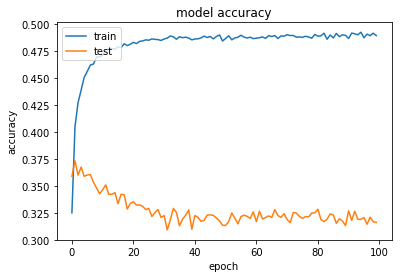

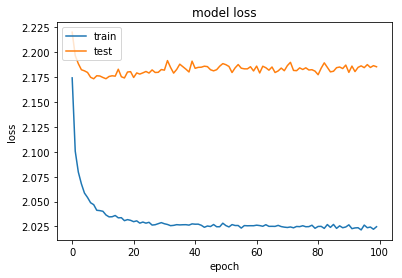

In [30]:
# compile the data
vnn_model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.RMSprop(),
    metrics=["accuracy"],
)

# keep track of the training
history_vnn = vnn_model.fit(X_train,
                            y_train, 
                            batch_size=32, 
                            epochs=100,
                            validation_data=(X_test, y_test))


# print the training/validation results
loss, accuracy = vnn_model.evaluate(X_train, y_train, verbose=1)

print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = vnn_model.evaluate(X_test, y_test, verbose=1)

print("Testing Accuracy:  {:.4f}".format(accuracy))

# list all data in history
print(history_vnn.history.keys())

# show history for accuracy
plt.plot(history_vnn.history['accuracy'])
plt.plot(history_vnn.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# show history for loss
plt.plot(history_vnn.history['loss'])
plt.plot(history_vnn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## RNN and CNN With Embedding Layer

This set of networks uses df2, not df -> see end of <b>Processing the Tokens</b> code

#### Regular CNN

In [31]:
# encode the genres as numbers (factors)
labelencoder_y_1 = LabelEncoder()
y = labelencoder_y_1.fit_transform(df2['genre'])

# perform a test/train split on the data
X_train, X_test, y_train, y_test = train_test_split(df2['lyrics'], y, test_size=0.2, random_state=42)

# use Keras tokenizer to tokenize the words and give a numerical index to the word
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

# find out the size of the vocabulary and save it as a variable
vocab_size = len(tokenizer.word_index) + 1
vocab_size

# use the tokenizer on the train and test data
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# find the average song length (by token count) by looping through each one and adding the length to a list
longest = []
for i in X_train:
    longest.append(len(i))
mean(longest)

# define the max length of the vectors as near this average
maxlen = 400

# pad the sequences if they don't reach the average length
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[0, :])

[ 448  479   40 4209   72  206   56  138  961  144 2287   65   14    5
  166   38 6011    3   20   28 2275    4   52    1 1339   96   39    1
  141  105   54   44    3    8   20  151   82   70    3   48  728  492
  479   40 1316   72  206   56  138  258  144 2287   65   14    5  166
   38 6011    3   20   28 2275    4   52    1 1339   96   39    1  141
  105   54   44    3    8   20  151   82    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [32]:
# input is the tokens as numbers from above

cnn_model = Sequential()
cnn_model.add(layers.Embedding(input_dim=vocab_size, 
                               output_dim=100, 
                               input_length=maxlen))

cnn_model.add(layers.Conv1D(256, 5))
cnn_model.add(layers.LeakyReLU())
cnn_model.add(layers.Dropout(0.5))
cnn_model.add(layers.MaxPooling1D())

cnn_model.add(layers.Conv1D(128, 3))
cnn_model.add(layers.LeakyReLU())
cnn_model.add(layers.Dropout(0.5))
cnn_model.add(layers.GlobalMaxPooling1D())

cnn_model.add(layers.Dense(10, activation='softmax'))

cnn_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 400, 100)          10271000  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 396, 256)          128256    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 396, 256)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 396, 256)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 198, 256)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 196, 128)          98432     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 196, 128)         

C:\Users\blitz\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 26080 samples, validate on 6520 samples
Epoch 1/50
26080/26080 [==============================] - 181s 7ms/step - loss: 1.9790 - accuracy: 0.2842 - val_loss: 1.9245 - val_accuracy: 0.3537
Epoch 2/50
26080/26080 [==============================] - 179s 7ms/step - loss: 1.6721 - accuracy: 0.4222 - val_loss: 1.8362 - val_accuracy: 0.3883
Epoch 3/50
26080/26080 [==============================] - 179s 7ms/step - loss: 1.4573 - accuracy: 0.4940 - val_loss: 1.7862 - val_accuracy: 0.3948
Epoch 4/50
26080/26080 [==============================] - 179s 7ms/step - loss: 1.2794 - accuracy: 0.5636 - val_loss: 1.7832 - val_accuracy: 0.4014
Epoch 5/50
26080/26080 [==============================] - 179s 7ms/step - loss: 1.1184 - accuracy: 0.6162 - val_loss: 1.7784 - val_accuracy: 0.4031
Epoch 6/50
26080/26080 [==============================] - 179s 7ms/step - loss: 0.9843 - accuracy: 0.6605 - val_loss: 1.8263 - val_accuracy: 0.3959
Epoch 7/50
26080/26080 [==============================] - 179s 

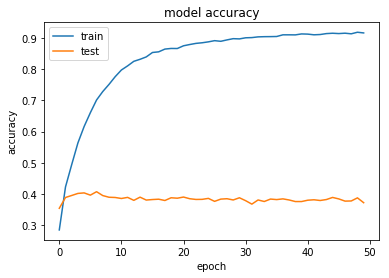

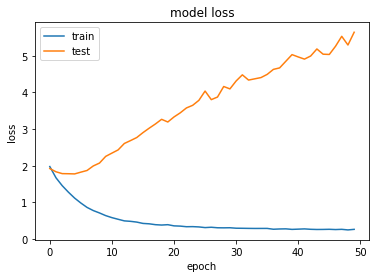

In [33]:
# keep track of the training
history_cnn = cnn_model.fit(X_train, y_train,
                        epochs=50,
                        verbose=1,
                        validation_data=(X_test, y_test),
                        batch_size=32)


# print the training/validation results
loss, accuracy = cnn_model.evaluate(X_train, y_train, verbose=1)

print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = cnn_model.evaluate(X_test, y_test, verbose=1)

print("Testing Accuracy:  {:.4f}".format(accuracy))

# list all data in history
print(history_cnn.history.keys())

# show history for accuracy
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# show history for loss
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Regular RNN

In [34]:
# encode the genres as numbers (factors)
labelencoder_y_1 = LabelEncoder()
y = labelencoder_y_1.fit_transform(df2['genre'])

# perform a test/train split on the data
X_train, X_test, y_train, y_test = train_test_split(df2['lyrics'], y, test_size=0.2, random_state=42)

# use Keras tokenizer to tokenize the words and give a numerical index to the word
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

# find out the size of the vocabulary and save it as a variable
vocab_size = len(tokenizer.word_index) + 1
vocab_size

# use the tokenizer on the train and test data
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# find the average song length (by token count) by looping through each one and adding the length to a list
longest = []
for i in X_train:
    longest.append(len(i))
mean(longest)

# define the max length of the vectors as near this average
maxlen = 300

# pad the sequences if they don't reach the average length
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[0, :])

[ 448  479   40 4209   72  206   56  138  961  144 2287   65   14    5
  166   38    3   20   28 2275    4   52    1 1339   96   39    1  141
  105   54   44    3    8   20  151   82   70    3   48  728  492  479
   40 1316   72  206   56  138  258  144 2287   65   14    5  166   38
    3   20   28 2275    4   52    1 1339   96   39    1  141  105   54
   44    3    8   20  151   82    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [35]:
# input is the tokens as numbers from above

rnn_model = Sequential()
rnn_model.add(layers.Embedding(input_dim=vocab_size, 
                               output_dim=100, 
                               input_length=maxlen))

rnn_model.add(layers.SpatialDropout1D(0.2))

rnn_model.add(layers.Bidirectional(layers.LSTM(200, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
rnn_model.add(layers.Bidirectional(layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))

rnn_model.add(layers.Flatten())

rnn_model.add(layers.Dense(10, activation='softmax'))

rnn_model.compile(optimizer='RMSprop',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

rnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 100)          10271000  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 300, 100)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 300, 400)          481600    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 300, 200)          400800    
_________________________________________________________________
flatten_1 (Flatten)          (None, 60000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                600010    
Total params: 11,753,410
Trainable params: 11,753,410
Non-trainable params: 0
__________________________________________

C:\Users\blitz\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 26080 samples, validate on 6520 samples
Epoch 1/25
26080/26080 [==============================] - 1688s 65ms/step - loss: 1.9824 - accuracy: 0.2895 - val_loss: 1.8326 - val_accuracy: 0.3512
Epoch 2/25
26080/26080 [==============================] - 1730s 66ms/step - loss: 1.7558 - accuracy: 0.3871 - val_loss: 1.8267 - val_accuracy: 0.3679
Epoch 3/25
26080/26080 [==============================] - 1736s 67ms/step - loss: 1.6009 - accuracy: 0.4479 - val_loss: 1.8988 - val_accuracy: 0.3755
Epoch 4/25
26080/26080 [==============================] - 1749s 67ms/step - loss: 1.4403 - accuracy: 0.5110 - val_loss: 1.8702 - val_accuracy: 0.3739
Epoch 5/25
26080/26080 [==============================] - 1744s 67ms/step - loss: 1.2577 - accuracy: 0.5757 - val_loss: 1.9714 - val_accuracy: 0.3748
Epoch 6/25
26080/26080 [==============================] - 1766s 68ms/step - loss: 1.0824 - accuracy: 0.6355 - val_loss: 2.1429 - val_accuracy: 0.3716
Epoch 7/25
26080/26080 [===========================

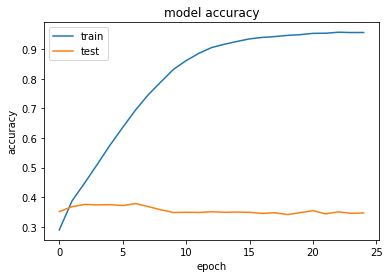

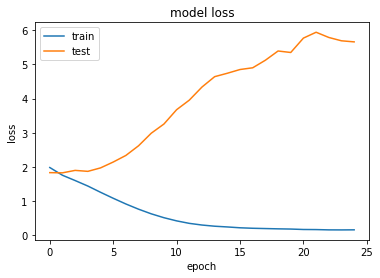

In [36]:
# keep track of the results
history_rnn = rnn_model.fit(X_train, y_train,
                        epochs=25,
                        verbose=1,
                        validation_data=(X_test, y_test),
                        batch_size=32)

loss, accuracy = rnn_model.evaluate(X_train, y_train, verbose=1)

print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = rnn_model.evaluate(X_test, y_test, verbose=1)

print("Testing Accuracy:  {:.4f}".format(accuracy))

# list all data in history
print(history_rnn.history.keys())

# show history for accuracy
plt.plot(history_rnn.history['accuracy'])
plt.plot(history_rnn.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# show history for loss
plt.plot(history_rnn.history['loss'])
plt.plot(history_rnn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### RNN and CNN Combined

Two-stream approach

In [37]:
# encode the genres as numbers (factors)
labelencoder_y_1 = LabelEncoder()
y = labelencoder_y_1.fit_transform(df2['genre'])

# perform a test/train split on the data
X_train, X_test, y_train, y_test = train_test_split(df2['lyrics'], y, test_size=0.2, random_state=42)

# use Keras tokenizer to tokenize the words and give a numerical index to the word
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

# find out the size of the vocabulary and save it as a variable
vocab_size = len(tokenizer.word_index) + 1
vocab_size

# use the tokenizer on the train and test data
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# find the average song length (by token count) by looping through each one and adding the length to a list
longest = []
for i in X_train:
    longest.append(len(i))
mean(longest)

# define the max length of the vectors as near this average
maxlen = 300

# pad the sequences if they don't reach the average length
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[0, :])

[ 448  479   40 4209   72  206   56  138  961  144 2287   65   14    5
  166   38 6011    3   20   28 2275    4   52    1 1339   96   39    1
  141  105   54   44    3    8   20  151   82   70    3   48  728  492
  479   40 1316   72  206   56  138  258  144 2287   65   14    5  166
   38 6011    3   20   28 2275    4   52    1 1339   96   39    1  141
  105   54   44    3    8   20  151   82    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [38]:
vocab_size

102710

In [39]:
# use Keras functional API to make a easier-to-read flow of the network
# input is the tokens as numbers from above

inputs = keras.Input(shape=(maxlen,))

embed = layers.Embedding(vocab_size,100)(inputs)

# CNN branch
x = layers.Conv1D(256, 5, activation='tanh')(embed)
x = layers.Dropout(0.5)(x)
x = layers.GlobalMaxPooling1D()(x)

# RNN branch
y = layers.SpatialDropout1D(0.2)(embed)
y = layers.LSTM(100, dropout=0.5, recurrent_dropout=0.5, return_sequences=True)(y)
y = layers.Flatten()(y)

# merge layer
merge_layer = layers.concatenate([x, y])
z = layers.Dense(64)(merge_layer)
z = layers.LeakyReLU()(z)

outputs = layers.Dense(10, activation='softmax')(z)

model_rnncnn1 = keras.Model(inputs=inputs, outputs=outputs, name="cnn_rnn_split_model")

model_rnncnn1.summary()

Model: "cnn_rnn_split_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 300, 100)     10271000    input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 296, 256)     128256      embedding_3[0][0]                
__________________________________________________________________________________________________
spatial_dropout1d_2 (SpatialDro (None, 300, 100)     0           embedding_3[0][0]                
________________________________________________________________________________

C:\Users\blitz\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 26080 samples, validate on 6520 samples
Epoch 1/50
26080/26080 [==============================] - 251s 10ms/step - loss: 2.1999 - accuracy: 0.2433 - val_loss: 2.1328 - val_accuracy: 0.3176
Epoch 2/50
26080/26080 [==============================] - 249s 10ms/step - loss: 2.1154 - accuracy: 0.3348 - val_loss: 2.0987 - val_accuracy: 0.3540
Epoch 3/50
26080/26080 [==============================] - 249s 10ms/step - loss: 2.0717 - accuracy: 0.3811 - val_loss: 2.1015 - val_accuracy: 0.3540
Epoch 4/50
26080/26080 [==============================] - 249s 10ms/step - loss: 2.0418 - accuracy: 0.4132 - val_loss: 2.0902 - val_accuracy: 0.3630
Epoch 5/50
26080/26080 [==============================] - 250s 10ms/step - loss: 2.0154 - accuracy: 0.4413 - val_loss: 2.0884 - val_accuracy: 0.3652
Epoch 6/50
26080/26080 [==============================] - 249s 10ms/step - loss: 1.9928 - accuracy: 0.4648 - val_loss: 2.0758 - val_accuracy: 0.3768
Epoch 7/50
26080/26080 [==============================] -

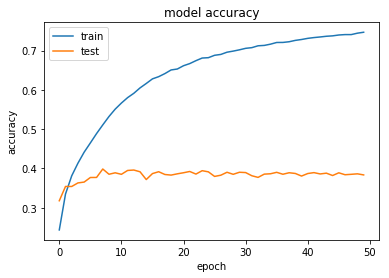

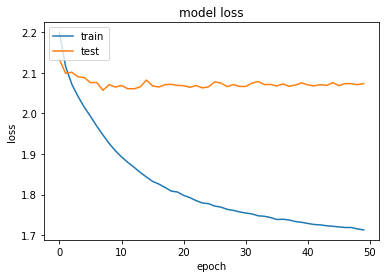

In [40]:
# compile the model
model_rnncnn1.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.RMSprop(),
    metrics=["accuracy"],
)

# keep track of the results
history_rnncnn1 = model_rnncnn1.fit(X_train,
                                    y_train, 
                                    batch_size=32,
                                    validation_data=(X_test, y_test),
                                    epochs=50)

# print the results
loss, accuracy = model_rnncnn1.evaluate(X_train, y_train, verbose=1)

print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model_rnncnn1.evaluate(X_test, y_test, verbose=1)

print("Testing Accuracy:  {:.4f}".format(accuracy))

# list all data in history
print(history_rnncnn1.history.keys())

# show history for accuracy
plt.plot(history_rnncnn1.history['accuracy'])
plt.plot(history_rnncnn1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# show history for loss
plt.plot(history_rnncnn1.history['loss'])
plt.plot(history_rnncnn1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

CNN/RNN Stepwise Approach

In [41]:
# encode the genres as numbers (factors)
labelencoder_y_1 = LabelEncoder()
y = labelencoder_y_1.fit_transform(df2['genre'])

# perform a test/train split on the data
X_train, X_test, y_train, y_test = train_test_split(df2['lyrics'], y, test_size=0.2, random_state=42)

# use Keras tokenizer to tokenize the words and give a numerical index to the word
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

# find out the size of the vocabulary and save it as a variable
vocab_size = len(tokenizer.word_index) + 1
vocab_size

# use the tokenizer on the train and test data
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# find the average song length (by token count) by looping through each one and adding the length to a list
longest = []
for i in X_train:
    longest.append(len(i))
mean(longest)

# define the max length of the vectors as near this average
maxlen = 300

# pad the sequences if they don't reach the average length
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[0, :])

[ 448  479   40 4209   72  206   56  138  961  144 2287   65   14    5
  166   38 6011    3   20   28 2275    4   52    1 1339   96   39    1
  141  105   54   44    3    8   20  151   82   70    3   48  728  492
  479   40 1316   72  206   56  138  258  144 2287   65   14    5  166
   38 6011    3   20   28 2275    4   52    1 1339   96   39    1  141
  105   54   44    3    8   20  151   82    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [42]:
# use Keras functional API to make a easier-to-read flow of the network

# input is the tokens as numbers from above

inputs = keras.Input(shape=(maxlen,))

embed = layers.Embedding(vocab_size,100)(inputs)

# CNN branches
x1 = layers.Conv1D(512, 5)(embed)
x1 = layers.LeakyReLU()(x1)
x1 = layers.Dropout(0.5)(x1)
x1 = layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(x1)

x2 = layers.Conv1D(256, 5)(embed)
x2 = layers.LeakyReLU()(x2)
x2 = layers.Dropout(0.5)(x2)
x2 = layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(x2)

x3 = layers.Conv1D(256, 5)(embed)
x3 = layers.LeakyReLU()(x3)
x3 = layers.Dropout(0.5)(x3)
x3 = layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(x3)

x4 = layers.Conv1D(128, 5)(embed)
x4 = layers.LeakyReLU()(x4)
x4 = layers.Dropout(0.5)(x4)
x4 = layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(x4)

x5 = layers.Conv1D(128, 5)(embed)
x5 = layers.LeakyReLU()(x5)
x5 = layers.Dropout(0.5)(x5)
x5 = layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(x5)

# merge the CNN layers
merge_layer = layers.Concatenate(axis=-1)([x1, x2, x3, x4, x5])

# RNN layer
y = layers.SpatialDropout1D(0.5)(merge_layer)
y = layers.Bidirectional(layers.LSTM(100, dropout=0.5, recurrent_dropout=0.5, return_sequences=True))(y)
y = layers.Flatten()(y)

outputs = layers.Dense(128)(y)
z = layers.LeakyReLU()(z)
z = layers.Dense(10, activation='softmax')(z)

model_rnncnn2 = keras.Model(inputs=inputs, outputs=outputs, name="cnn_to_rnn_model")

model_rnncnn2.summary()

Model: "cnn_to_rnn_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 300, 100)     10271000    input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 296, 512)     256512      embedding_4[0][0]                
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 296, 256)     128256      embedding_4[0][0]                
___________________________________________________________________________________

C:\Users\blitz\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 26080 samples, validate on 6520 samples
Epoch 1/20
26080/26080 [==============================] - 1017s 39ms/step - loss: 1.9320 - accuracy: 0.3152 - val_loss: 1.8367 - val_accuracy: 0.3469
Epoch 2/20
26080/26080 [==============================] - 1016s 39ms/step - loss: 1.7297 - accuracy: 0.3995 - val_loss: 1.7867 - val_accuracy: 0.3896
Epoch 3/20
26080/26080 [==============================] - 1008s 39ms/step - loss: 1.5707 - accuracy: 0.4633 - val_loss: 1.8295 - val_accuracy: 0.3893
Epoch 4/20
26080/26080 [==============================] - 974s 37ms/step - loss: 1.4284 - accuracy: 0.5138 - val_loss: 1.8946 - val_accuracy: 0.3992
Epoch 5/20
26080/26080 [==============================] - 969s 37ms/step - loss: 1.2932 - accuracy: 0.5653 - val_loss: 2.1037 - val_accuracy: 0.3891
Epoch 6/20
26080/26080 [==============================] - 968s 37ms/step - loss: 1.1564 - accuracy: 0.6138 - val_loss: 2.3195 - val_accuracy: 0.3813
Epoch 7/20
26080/26080 [==============================

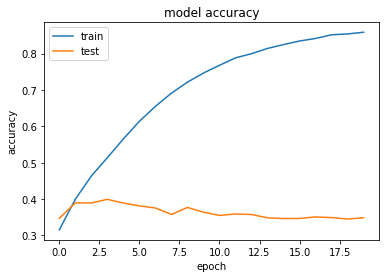

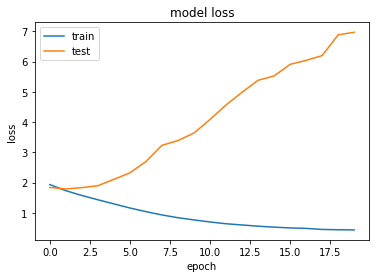

In [45]:
# compile the model
model_rnncnn2.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.RMSprop(),
    metrics=["accuracy"],
)

# keep track of the results
history_rnncnn2 = model_rnncnn2.fit(X_train,
                                    y_train, 
                                    batch_size=32, 
                                    epochs=20,
                                    validation_data=(X_test, y_test))


# print the results
loss, accuracy = model_rnncnn2.evaluate(X_train, y_train, verbose=1)

print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model_rnncnn2.evaluate(X_test, y_test, verbose=1)

print("Testing Accuracy:  {:.4f}".format(accuracy))

# list all data in history
print(history_rnncnn2.history.keys())

# show history for accuracy
plt.plot(history_rnncnn2.history['accuracy'])
plt.plot(history_rnncnn2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# show history for loss
plt.plot(history_rnncnn2.history['loss'])
plt.plot(history_rnncnn2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()